<font color="green">**K-Nearest Neighbors model for stock prediction using stock data**</font>

**Import Libraries**

In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd

#Data Scaling Libraries
from sklearn.preprocessing import MinMaxScaler

#Error Metrics Libraries
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#KNN Libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

#Data Visualization Library
plt.style.use('fivethirtyeight')

**Get stock data and visualize**

In [2]:
#Get the stock quote for Disney
df = web.DataReader('DIS', data_source='yahoo', start='2016-07-22', end='2020-05-26') 

#Use the below code to get stock quotes for other companies: Apple, AMD, Tesla
#df = web.DataReader('AAPL', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('TSLA', data_source='yahoo', start='2016-07-22', end='2020-10-30')

#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,98.419998,97.470001,98.389999,97.709999,5381700.0,92.853477
2016-07-25,98.059998,97.250000,97.900002,97.389999,4825500.0,92.549377
2016-07-26,97.160004,96.339996,97.019997,96.690002,6274800.0,91.884163
2016-07-27,96.930000,95.860001,96.699997,96.330002,6911400.0,91.542076
2016-07-28,96.489998,95.820000,96.400002,95.910004,7713500.0,91.142944


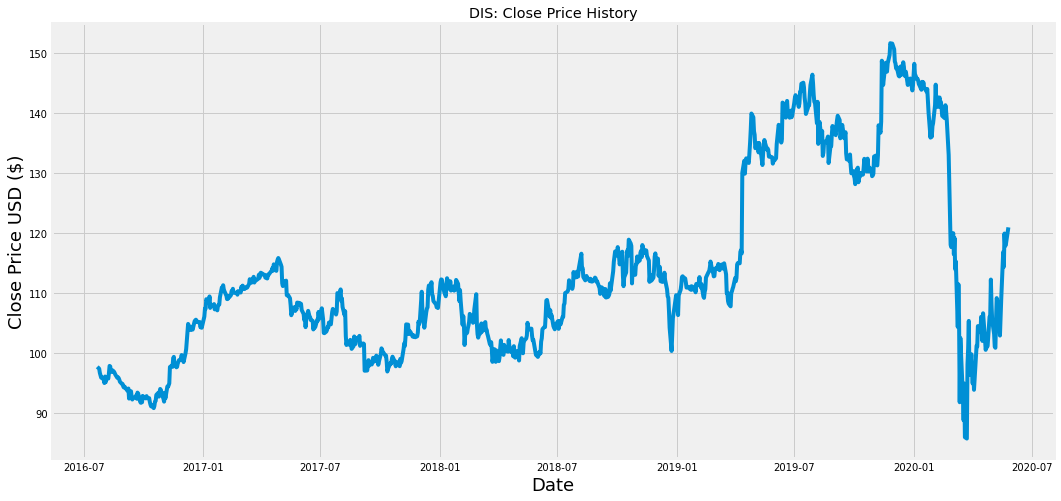

In [3]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('DIS: Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess data and split into train-test datasets**

In [4]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

print("Training Data Length: ", training_data_len)

Training Data Length:  774


In [5]:
#Scale the all of the data to be values between 0 to 1 range
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [6]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [7]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [9]:
x_train.shape

(714, 60)

In [10]:
x_test.shape

(193, 60)

**KNN: Build model and train using the training data**

In [11]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[1,2,3,4,5]}
knn = neighbors.KNeighborsRegressor(n_neighbors=5)  ## Neighbors with size 1,5,20 is tested with 5 as the optimal performer
model = GridSearchCV(knn, params, cv=10)

#fit the model on training data
model.fit(x_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

**Predict on testing data and visualize predictions**

In [12]:
preds = model.predict(x_test)
preds = preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)#Undo scaling

rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
print("RMS: ",rms)

RMS:  12.871836466520975


In [13]:
#Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


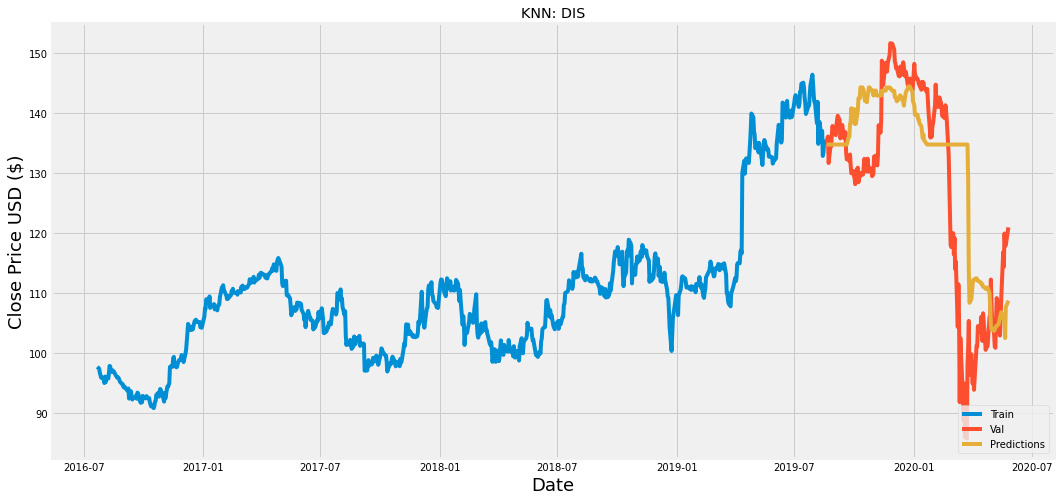

In [14]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('KNN: DIS')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()